<a href="https://colab.research.google.com/github/lohi629/python.py/blob/main/week5assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)]) #mean and std have to be sequences (e.g., tuples), 
                                                                      # therefore we should add a comma after the values
                          
#Load the data: train and test sets
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)

#Preparing for validaion test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
#to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

#Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [5]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /root/.pytorch/F_MNIST_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [6]:
trainloader

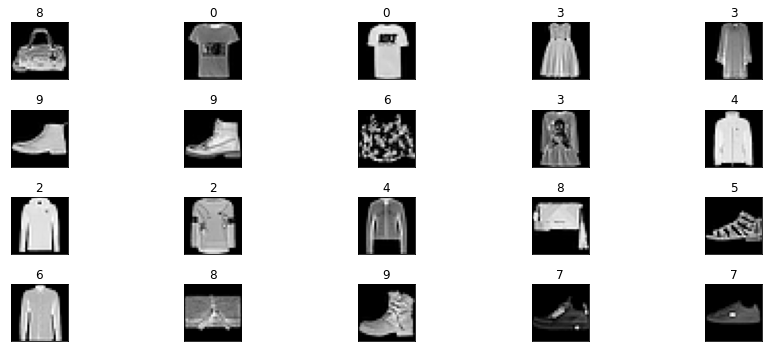

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()


fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  # xticks=[], yticks=[] is empty to print the images without any ticks around them
  #np.sqeeze : Remove single-dimensional entries from the shape of an array.
  ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
   # .item() gets the value contained in a Tensor
  ax.set_title(labels[idx].item())
  fig.tight_layout()

In [8]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 120)
    self.fc2 = nn.Linear(120, 120)
    self.fc3 = nn.Linear(120,10)
    #self.fc4 = nn.Linear(64,10)
    #defining the 20% dropout
    self.dropout = nn.Dropout(0.2)

  def forward(self,x):
    x = x.view(x.shape[0],-1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    #x = self.dropout(F.relu(self.fc3(x)))
    #not using dropout on output layer
    x = F.log_softmax(self.fc3(x), dim=1)
    return x   

In [9]:
model = Classifier()
#defining the loss function
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

valid_loss_min = np.Inf #using this high value to make sure the update the weight first time
epochs = 40
steps = 0
model.train() #prep model for training
train_losses, valid_losses = [],[]
for e in range(epochs):
  running_loss =0 
  valid_loss = 0
   # train the model #
  for images, labels in trainloader:

     optimizer.zero_grad()
     log_ps = model(images)
     loss = criterion(log_ps, labels)
     loss.backward()
     optimizer.step()
     running_loss += loss.item()*images.size(0)
  
  for images, labels in validloader:
     log_ps = model(images)
     loss = criterion(log_ps, labels)
     valid_loss += loss.item()*images.size(0)

  running_loss = running_loss/len(trainloader.sampler)
  valid_loss =  valid_loss/len(validloader.sampler)
  train_losses.append(running_loss)
  valid_losses.append(valid_loss)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1,
        running_loss,
        valid_loss
    ))
  if valid_loss <= valid_loss_min:
      print('validation loss decreased({:.6f} -->{:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
      torch.save(model.state_dict(), 'model.pt')
      valid_loss_min = valid_loss

  

Epoch: 1 	Training Loss: 1.936888 	Validation Loss: 1.458380
validation loss decreased(inf -->1.458380). Saving Model ...
Epoch: 2 	Training Loss: 1.200144 	Validation Loss: 1.026046
validation loss decreased(1.458380 -->1.026046). Saving Model ...
Epoch: 3 	Training Loss: 0.930659 	Validation Loss: 0.862856
validation loss decreased(1.026046 -->0.862856). Saving Model ...
Epoch: 4 	Training Loss: 0.805841 	Validation Loss: 0.783669
validation loss decreased(0.862856 -->0.783669). Saving Model ...
Epoch: 5 	Training Loss: 0.742594 	Validation Loss: 0.726917
validation loss decreased(0.783669 -->0.726917). Saving Model ...
Epoch: 6 	Training Loss: 0.697627 	Validation Loss: 0.688253
validation loss decreased(0.726917 -->0.688253). Saving Model ...
Epoch: 7 	Training Loss: 0.670443 	Validation Loss: 0.663029
validation loss decreased(0.688253 -->0.663029). Saving Model ...
Epoch: 8 	Training Loss: 0.639166 	Validation Loss: 0.637377
validation loss decreased(0.663029 -->0.637377). Saving

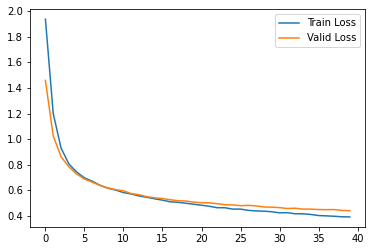

In [10]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()

In [11]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [12]:
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


model.eval()
for images, labels in testloader:
  #forword pass 
  output = model(images)
  #calculate the loss
  loss = criterion(output, labels)
  #update the test loss
  test_loss += loss.item()*images.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  #compare predictions to the true labes
  correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
  #calculate test accuracy for each object class
  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] +=1

#calcaulate and prınt test loss
test_loss = test_loss/len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%
          (str(i), 100 * class_correct[i]/class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A(no training examples)' % classes[i])

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.426168

Test Accuracy of     0: 86% (866/1000)
Test Accuracy of     1: 95% (952/1000)
Test Accuracy of     2: 79% (795/1000)
Test Accuracy of     3: 86% (866/1000)
Test Accuracy of     4: 72% (728/1000)
Test Accuracy of     5: 91% (915/1000)
Test Accuracy of     6: 53% (534/1000)
Test Accuracy of     7: 92% (929/1000)
Test Accuracy of     8: 94% (947/1000)
Test Accuracy of     9: 92% (920/1000)

Test Accuracy (Overall): 84% (8452/10000)


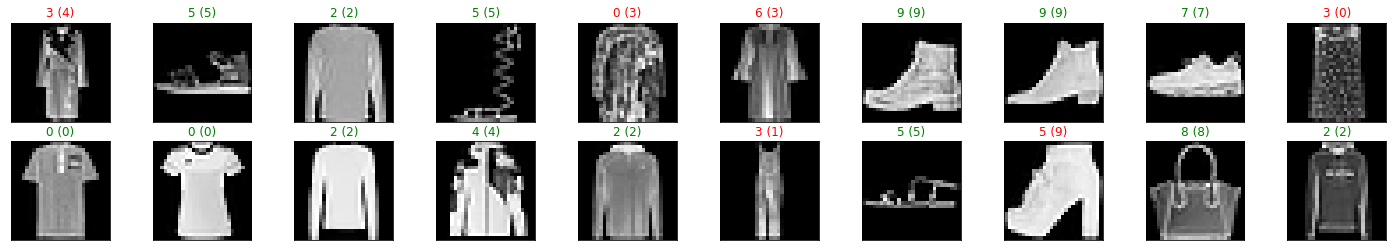

In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))